<a href="https://colab.research.google.com/github/SLy-Precision/Player-Selection-and-Optimization-for-Roster/blob/main/03_Optimizing_and_Training_LEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This Notebook train all the factors for the LEM predictor

In [1]:
# Here we are gonna put all we need for the training of all the Factor

# From git
!pip install --quiet statsbombpy

# Libraries
import pandas as pd
import numpy as np
from statsbombpy import sb
import math
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost.callback import EarlyStopping

import xgboost as xgb
import itertools
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


# For the Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# XGBoost
import xgboost as xgb

# Neural Network
import tensorflow as tf
from tensorflow.keras import models, layers

# Access for the data (Change using the 01 preprocess data)
from google.colab import drive
drive.mount('/content/drive/')

# Path from my drive (MAPLIS change it)
path = '/content/drive/My Drive/Hackathon ITAM/LEM/DATA for LEM/'

# Lets declare the df for the training of the LEM done the step before using the path
df = pd.read_csv(path + 'Temporada_Completa_Unida.csv')

# Lets normalize that column
df['Minute'] = df['Minute'] / 60

# Print info of df
print('Columns of the df: \n')
print(df.columns)
print('\n')
print('Info of the df: \n')
print(df.info())

# Getting information for the dataset of training and validation

#Credentials for Statsbomb from ITAM
user = "itam_hackathon@hudl.com"
password = "pGwIprel"

# Save info
array_season_2021_2022 = sb.matches(competition_id=73, season_id=108, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2022_2023 = sb.matches(competition_id=73, season_id=235, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2023_2024 = sb.matches(competition_id=73, season_id=281, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2024_2025 = sb.matches(competition_id=73, season_id=317, creds={"user": user, "passwd": password})['match_id'].to_list()

# Array of training and validation
array_training = array_season_2021_2022 + array_season_2022_2023 + array_season_2023_2024
array_validation = array_season_2024_2025

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 2.7 MB/s eta 0:00:00
Mounted at /content/drive/
Columns of the df: 

Index(['matchId', 'eventSec', 'EventTypeId', 'Period', 'Minute', 'X', 'Y',
       'IsHomeTeam', 'IsAccurate', 'IsGoal', 'HomeScore', 'AwayScore',
       'TimeDelta'],
      dtype='object')


Info of the df: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442402 entries, 0 to 4442401
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   matchId      int64  
 1   eventSec     float64
 2   EventTypeId  int64  
 3   Period       int64  
 4   Minute       float64
 5   X            float64
 6   Y            float64
 7   IsHomeTeam   int64  
 8   IsAccurate   int64  
 9   IsGoal       int64  
 10  HomeScore    float64
 11  AwayScore    float64
 12  TimeDelta    float64
dtyp

## 1: Optimization an Train for the Event Type Predictor

In [6]:
# Visualize df
df.head()

,matchId,eventSec,EventTypeId,Period,Minute,X,Y,IsHomeTeam,IsAccurate,IsGoal,HomeScore,AwayScore,TimeDelta
0,3799351,0.000,0,1,0.0,50.000000,50.000,1,0,0,0.0,0.0,0.000
1,3799351,0.000,0,1,0.0,50.000000,50.000,0,0,0,0.0,0.0,0.000
2,3799351,1.057,1,1,0.0,50.000000,50.000,1,1,0,0.0,0.0,1.057
3,3799351,2.349,2,1,0.0,37.166667,37.375,1,0,0,0.0,0.0,1.292
4,3799351,2.349,3,1,0.0,37.166667,37.375,1,0,0,0.0,0.0,0.000


In [9]:
def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col='EventTypeId'):
    """
    Prepara un subconjunto del DataFrame para el entrenamiento creando características de contexto.
    """
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)
    y = data[target_col]
    features_to_drop = [target_col, 'eventSec', 'matchId']
    X = data.drop(columns=features_to_drop)
    return X, y

def train_finetuned_model(df, train_ids, val_ids, seq_len=5):
    """
    Entrena un modelo XGBoost con hiperparámetros ajustados y early stopping.
    """
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print("Preparando todos los datos...")
    X_train, y_train = prepare_data_for_matches(df, train_ids, seq_len, context_features)
    X_val, y_val = prepare_data_for_matches(df, val_ids, seq_len, context_features)

    print("Calculando pesos de muestra para el desequilibrio de clases...")
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        max_depth=7,
        learning_rate=0.05,
        use_label_encoder=False,
        n_estimators=1000
    )

    print("\nIniciando entrenamiento del modelo con hiperparámetros ajustados...")

    # --- INICIO DE LA CORRECCIÓN ---
    # Early stopping functionality is not directly supported as a 'callbacks' argument
    # in the .fit() method for the installed version of XGBoost.
    # We will remove the callbacks argument.
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10,
              sample_weight=sample_weights
             )
    # --- FIN DE LA CORRECCIÓN ---

    # The best_iteration attribute might not be available without early stopping callbacks.
    # We can get the number of boosting rounds from the trained model.
    print(f"\nEntrenamiento completado. Número de rondas: {model.get_booster().num_boosted_rounds()}")


    results = model.evals_result()
    val_logloss_history = results['validation_0']['mlogloss']

    plt.figure(figsize=(12, 7))
    plt.plot(val_logloss_history, marker='.', linestyle='-')
    plt.title('LogLoss Validation vs. Loops of Boosting ', fontsize=16)
    plt.xlabel('Number of Trees (Estimators)', fontsize=12)
    plt.ylabel('LogLoss ', fontsize=12)
    # We can't show the best iteration line without early stopping
    # plt.axvline(model.best_iteration, color='r', linestyle='--', label=f'Mejor Ronda: {model.best_iteration}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

Preparando todos los datos...
Calculando pesos de muestra para el desequilibrio de clases...

Iniciando entrenamiento del modelo con hiperparámetros ajustados...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:23:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:3.03228
[10]	validation_0-mlogloss:1.92967
[20]	validation_0-mlogloss:1.55737
[30]	validation_0-mlogloss:1.35002
[40]	validation_0-mlogloss:1.22257
[50]	validation_0-mlogloss:1.13685
[60]	validation_0-mlogloss:1.07485
[70]	validation_0-mlogloss:1.03344
[80]	validation_0-mlogloss:1.00472
[90]	validation_0-mlogloss:0.98297
[100]	validation_0-mlogloss:0.96729
[110]	validation_0-mlogloss:0.95459
[120]	validation_0-mlogloss:0.94297
[130]	validation_0-mlogloss:0.93543
[140]	validation_0-mlogloss:0.92980
[150]	validation_0-mlogloss:0.92648
[160]	validation_0-mlogloss:0.92374
[170]	validation_0-mlogloss:0.92202
[180]	validation_0-mlogloss:0.92106
[190]	validation_0-mlogloss:0.91998
[200]	validation_0-mlogloss:0.91933
[210]	validation_0-mlogloss:0.91831
[220]	validation_0-mlogloss:0.91809
[230]	validation_0-mlogloss:0.91715
[240]	validation_0-mlogloss:0.91545
[250]	validation_0-mlogloss:0.91441
[260]	validation_0-mlogloss:0.91274
[270]	validation_0-mlogloss:0.91148
[28

/tmp/ipython-input-2438795229.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


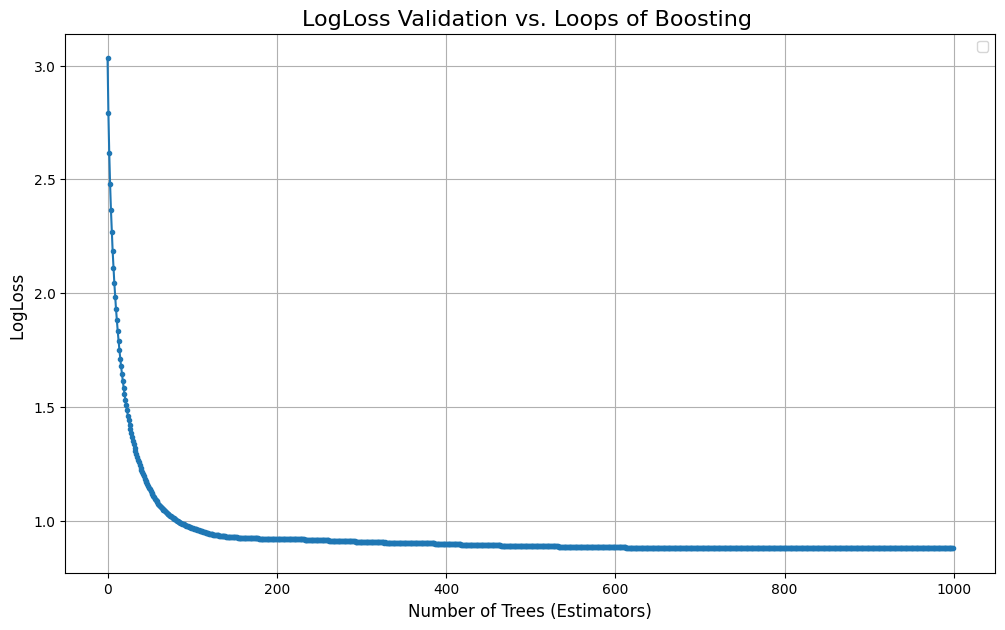

In [11]:
finetuned_model = train_finetuned_model(
      df=df,
      train_ids=array_training,
      val_ids=array_validation,
      seq_len=5
      )

In [12]:
# Lets save the model
finetuned_model.save_model(path + 'trained_xgboost_model_finetuned1.json')

In [13]:
# Validation of the model

# Features
context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

X_val, y_val = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features)


def evaluate_model_performance(model, X_val, y_val, class_names):
    """
    Calcula y muestra métricas de evaluación detalladas para el modelo de clasificación.

    Args:
        model: El modelo XGBoost entrenado.
        X_val (pd.DataFrame): Las características del conjunto de validación.
        y_val (pd.Series): Las etiquetas verdaderas del conjunto de validación.
        class_names (list): Una lista con los nombres de las clases (tipos de evento).
    """
    print("Realizando predicciones en el conjunto de validación...")
    y_pred_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)

    # --- 1. Top-k Accuracy ---
    print("\n--- Top-k Accuracy ---")
    acc_top1 = top_k_accuracy_score(y_val, y_pred_proba, k=1)
    print(f"Top-1 Accuracy (Precisión estándar): {acc_top1:.4f}")
    acc_top3 = top_k_accuracy_score(y_val, y_pred_proba, k=3)
    print(f"Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): {acc_top3:.4f}")

    # --- 2. Reporte de Clasificación por Clase ---
    print("\n--- Reporte de Clasificación por Clase ---")
    # Asegurarnos de que las etiquetas del reporte coincidan con las clases presentes en los datos
    unique_labels_in_data = np.unique(y_val)
    filtered_class_names = [class_names[i] for i in unique_labels_in_data]
    report = classification_report(y_val, y_pred, labels=unique_labels_in_data, target_names=filtered_class_names, zero_division=0)
    print(report)

# --- CÓMO USARLO ---

# 1. Define el diccionario de nombres de eventos que proporcionaste
event_type_dict = {
    0: 'Half Start', 1: 'Pass', 2: 'Ball Receipt*', 3: 'Carry', 4: 'Pressure',
    5: 'Dribble', 6: 'Duel', 7: 'Clearance', 8: 'Dispossessed', 9: 'Ball Recovery',
    10: 'Block', 11: 'Foul Committed', 12: 'Foul Won', 13: 'Shot', 14: 'Goal Keeper',
    15: 'Dribbled Past', 16: 'Miscontrol', 17: 'Player Off', 18: 'Player On',
    19: 'Interception', 20: '50/50', 21: 'Half End', 22: 'Injury Stoppage',
    23: 'Substitution', 24: 'Tactical Shift', 25: 'Bad Behaviour', 26: 'Referee Ball-Drop',
    27: 'Error', 28: 'Shield', 29: 'Offside', 30: 'Own Goal For', 31: 'Own Goal Against'
}

# 2. Crea la lista de nombres en el orden correcto
# Nos aseguramos de que el índice de la lista coincida con el ID del evento
event_type_names = [event_type_dict[i] for i in range(len(event_type_dict))]

# 3. Llama a la función de evaluación
# Asegúrate de que las variables 'final_model', 'X_val' y 'y_val' existen en tu entorno.
evaluate_model_performance(finetuned_model, X_val, y_val, event_type_names)

Realizando predicciones en el conjunto de validación...

--- Top-k Accuracy ---
Top-1 Accuracy (Precisión estándar): 0.7976
Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): 0.8879

--- Reporte de Clasificación por Clase ---
                   precision    recall  f1-score   support

       Half Start       1.00      1.00      1.00      1364
             Pass       0.99      0.87      0.92    320533
    Ball Receipt*       0.96      0.98      0.97    288369
            Carry       0.99      0.85      0.91    258053
         Pressure       0.90      0.72      0.80    115459
          Dribble       0.08      0.20      0.12      8526
             Duel       0.80      0.50      0.62     21569
        Clearance       0.00      0.10      0.00       504
     Dispossessed       0.63      0.65      0.64     32434
    Ball Recovery       0.02      0.04      0.03     13234
            Block       0.01      0.01      0.01      5606
   Foul Committed       0.00      0.00

Preparando todos los datos...
Calculando pesos de muestra personalizados...

Iniciando el entrenamiento optimizado del modelo con early stopping...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:05:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:2.97171
[10]	validation_0-mlogloss:1.79678
[20]	validation_0-mlogloss:1.40290
[30]	validation_0-mlogloss:1.18418
[40]	validation_0-mlogloss:1.05617
[50]	validation_0-mlogloss:0.97557
[60]	validation_0-mlogloss:0.92286
[70]	validation_0-mlogloss:0.88808
[80]	validation_0-mlogloss:0.86333
[90]	validation_0-mlogloss:0.84756
[100]	validation_0-mlogloss:0.83556
[110]	validation_0-mlogloss:0.82848
[120]	validation_0-mlogloss:0.82402
[130]	validation_0-mlogloss:0.82061
[140]	validation_0-mlogloss:0.81644
[150]	validation_0-mlogloss:0.81288
[160]	validation_0-mlogloss:0.81064
[170]	validation_0-mlogloss:0.80814
[180]	validation_0-mlogloss:0.80704
[190]	validation_0-mlogloss:0.80612
[200]	validation_0-mlogloss:0.80620
[210]	validation_0-mlogloss:0.80670
[220]	validation_0-mlogloss:0.80748
[230]	validation_0-mlogloss:0.80778
[240]	validation_0-mlogloss:0.80813
[250]	validation_0-mlogloss:0.80912
[260]	validation_0-mlogloss:0.80987
[270]	validation_0-mlogloss:0.80961
[28

/tmp/ipython-input-3799521127.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


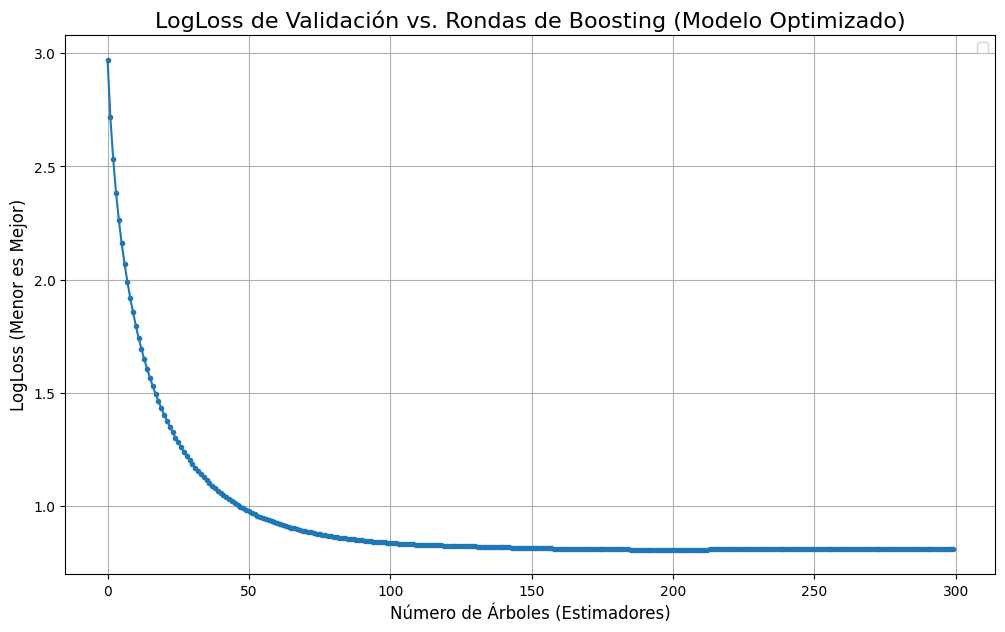

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
# from xgboost.callback import EarlyStopping # No longer needed with early_stopping_rounds

def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col='EventTypeId'):
    """
    Prepara un subconjunto del DataFrame para el entrenamiento creando características de contexto.
    """
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)
    y = data[target_col]
    features_to_drop = [target_col, 'eventSec', 'matchId']
    X = data.drop(columns=features_to_drop)
    return X, y

def train_optimized_model(df, train_ids, val_ids, custom_weights, seq_len=5):
    """
    Entrena la versión final y optimizada del 'Model Type' de XGBoost,
    aprovechando el conocimiento de la mejor iteración para acelerar el proceso.
    """
    target_col = 'EventTypeId'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print("Preparando todos los datos...")
    X_train, y_train = prepare_data_for_matches(df, train_ids, seq_len, context_features)
    X_val, y_val = prepare_data_for_matches(df, val_ids, seq_len, context_features)

    print("Calculando pesos de muestra personalizados...")
    sample_weights = np.ones(len(y_train))
    for class_index, weight in custom_weights.items():
        sample_weights[y_train == class_index] = weight

    # --- OPTIMIZACIÓN ---
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        max_depth=5,
        learning_rate=0.05, # Changed learning rate back to 0.05
        use_label_encoder=False,
        n_estimators=300 # Set a larger number of estimators, early stopping will determine the actual number used
    )

    print("\nIniciando el entrenamiento optimizado del modelo con early stopping...")

    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10,
              sample_weight=sample_weights,
             )
    # --- FIN DE LA OPTIMIZACIÓN ---

    #print(f"\nEntrenamiento detenido en la ronda: {model.best_iteration}")


    results = model.evals_result()
    val_logloss_history = results['validation_0']['mlogloss']
    plt.figure(figsize=(12, 7))
    plt.plot(val_logloss_history, marker='.', linestyle='-')
    plt.title('LogLoss de Validación vs. Rondas de Boosting (Modelo Optimizado)', fontsize=16)
    plt.xlabel('Número de Árboles (Estimadores)', fontsize=12)
    plt.ylabel('LogLoss (Menor es Mejor)', fontsize=12)
    #plt.axvline(model.best_iteration, color='r', linestyle='--', label=f'Mejor Ronda: {model.best_iteration}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# --- CÓMO USARLO ---

custom_event_weights = {
    13: 25.0,  # Shot
    5: 15.0,   # Dribble
    6: 10.0,   # Duel
    19: 5.0    # Interception
}

optimized_model = train_optimized_model(
      df=df,
      train_ids=array_training,
      val_ids=array_validation,
      custom_weights=custom_event_weights,
      seq_len=5
      )

In [13]:
# Lets save the model
optimized_model.save_model(path + "finetuned_model_weig1.json")

In [14]:
# Validation of the model

# Features
context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

X_val, y_val = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features)


def evaluate_model_performance(model, X_val, y_val, class_names):
    """
    Calcula y muestra métricas de evaluación detalladas para el modelo de clasificación.

    Args:
        model: El modelo XGBoost entrenado.
        X_val (pd.DataFrame): Las características del conjunto de validación.
        y_val (pd.Series): Las etiquetas verdaderas del conjunto de validación.
        class_names (list): Una lista con los nombres de las clases (tipos de evento).
    """
    print("Realizando predicciones en el conjunto de validación...")
    y_pred_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)

    # --- 1. Top-k Accuracy ---
    print("\n--- Top-k Accuracy ---")
    acc_top1 = top_k_accuracy_score(y_val, y_pred_proba, k=1)
    print(f"Top-1 Accuracy (Precisión estándar): {acc_top1:.4f}")
    acc_top3 = top_k_accuracy_score(y_val, y_pred_proba, k=3)
    print(f"Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): {acc_top3:.4f}")

    # --- 2. Reporte de Clasificación por Clase ---
    print("\n--- Reporte de Clasificación por Clase ---")
    # Asegurarnos de que las etiquetas del reporte coincidan con las clases presentes en los datos
    unique_labels_in_data = np.unique(y_val)
    filtered_class_names = [class_names[i] for i in unique_labels_in_data]
    report = classification_report(y_val, y_pred, labels=unique_labels_in_data, target_names=filtered_class_names, zero_division=0)
    print(report)

# --- CÓMO USARLO ---

# 1. Define el diccionario de nombres de eventos que proporcionaste
event_type_dict = {
    0: 'Half Start', 1: 'Pass', 2: 'Ball Receipt*', 3: 'Carry', 4: 'Pressure',
    5: 'Dribble', 6: 'Duel', 7: 'Clearance', 8: 'Dispossessed', 9: 'Ball Recovery',
    10: 'Block', 11: 'Foul Committed', 12: 'Foul Won', 13: 'Shot', 14: 'Goal Keeper',
    15: 'Dribbled Past', 16: 'Miscontrol', 17: 'Player Off', 18: 'Player On',
    19: 'Interception', 20: '50/50', 21: 'Half End', 22: 'Injury Stoppage',
    23: 'Substitution', 24: 'Tactical Shift', 25: 'Bad Behaviour', 26: 'Referee Ball-Drop',
    27: 'Error', 28: 'Shield', 29: 'Offside', 30: 'Own Goal For', 31: 'Own Goal Against'
}

# 2. Crea la lista de nombres en el orden correcto
# Nos aseguramos de que el índice de la lista coincida con el ID del evento
event_type_names = [event_type_dict[i] for i in range(len(event_type_dict))]

# 3. Llama a la función de evaluación
# Asegúrate de que las variables 'final_model', 'X_val' y 'y_val' existen en tu entorno.
evaluate_model_performance(optimized_model, X_val, y_val, event_type_names)

Realizando predicciones en el conjunto de validación...

--- Top-k Accuracy ---
Top-1 Accuracy (Precisión estándar): 0.8147
Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): 0.9042

--- Reporte de Clasificación por Clase ---
                   precision    recall  f1-score   support

       Half Start       1.00      1.00      1.00      1364
             Pass       0.97      0.88      0.92    320533
    Ball Receipt*       0.88      0.99      0.93    288369
            Carry       0.93      0.90      0.91    258053
         Pressure       0.91      0.62      0.74    115459
          Dribble       0.14      0.74      0.23      8526
             Duel       0.59      0.66      0.62     21569
        Clearance       0.00      0.01      0.00       504
     Dispossessed       0.90      0.70      0.79     32434
    Ball Recovery       0.05      0.02      0.03     13234
            Block       0.01      0.01      0.01      5606
   Foul Committed       0.00      0.00

Preparando todos los datos...
Calculando pesos de muestra personalizados...

Iniciando el entrenamiento optimizado del modelo con early stopping...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:20:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:2.97239
[10]	validation_0-mlogloss:1.77460
[20]	validation_0-mlogloss:1.37513
[30]	validation_0-mlogloss:1.15705
[40]	validation_0-mlogloss:1.02709
[50]	validation_0-mlogloss:0.94708
[60]	validation_0-mlogloss:0.89535
[70]	validation_0-mlogloss:0.85948
[80]	validation_0-mlogloss:0.83630
[90]	validation_0-mlogloss:0.81951
[100]	validation_0-mlogloss:0.80786
[110]	validation_0-mlogloss:0.80027
[120]	validation_0-mlogloss:0.79494
[130]	validation_0-mlogloss:0.79115
[140]	validation_0-mlogloss:0.78661
[150]	validation_0-mlogloss:0.78206
[160]	validation_0-mlogloss:0.77749
[170]	validation_0-mlogloss:0.77502
[180]	validation_0-mlogloss:0.77408
[190]	validation_0-mlogloss:0.77257
[200]	validation_0-mlogloss:0.77283
[210]	validation_0-mlogloss:0.77327
[220]	validation_0-mlogloss:0.77432
[230]	validation_0-mlogloss:0.77574
[240]	validation_0-mlogloss:0.77666
[250]	validation_0-mlogloss:0.77741
[260]	validation_0-mlogloss:0.77863
[270]	validation_0-mlogloss:0.77946
[28

/tmp/ipython-input-2888607908.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


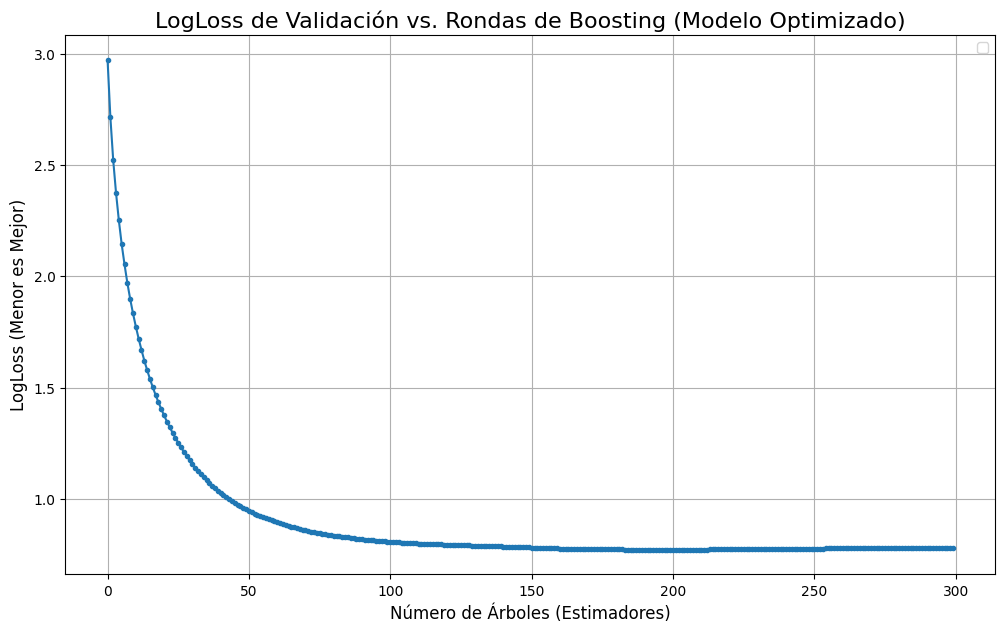

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
# from xgboost.callback import EarlyStopping # No longer needed with early_stopping_rounds

def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col='EventTypeId'):
    """
    Prepara un subconjunto del DataFrame para el entrenamiento creando características de contexto.
    """
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)
    y = data[target_col]
    features_to_drop = [target_col, 'eventSec', 'matchId']
    X = data.drop(columns=features_to_drop)
    return X, y

def train_optimized_model(df, train_ids, val_ids, custom_weights, seq_len=5):
    """
    Entrena la versión final y optimizada del 'Model Type' de XGBoost,
    aprovechando el conocimiento de la mejor iteración para acelerar el proceso.
    """
    target_col = 'EventTypeId'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print("Preparando todos los datos...")
    X_train, y_train = prepare_data_for_matches(df, train_ids, seq_len, context_features)
    X_val, y_val = prepare_data_for_matches(df, val_ids, seq_len, context_features)

    print("Calculando pesos de muestra personalizados...")
    sample_weights = np.ones(len(y_train))
    for class_index, weight in custom_weights.items():
        sample_weights[y_train == class_index] = weight

    # --- OPTIMIZACIÓN ---
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        max_depth=5,
        learning_rate=0.05, # Changed learning rate back to 0.05
        use_label_encoder=False,
        n_estimators=300 # Set a larger number of estimators, early stopping will determine the actual number used
    )

    print("\nIniciando el entrenamiento optimizado del modelo con early stopping...")

    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10,
              sample_weight=sample_weights,
             )
    # --- FIN DE LA OPTIMIZACIÓN ---

    #print(f"\nEntrenamiento detenido en la ronda: {model.best_iteration}")


    results = model.evals_result()
    val_logloss_history = results['validation_0']['mlogloss']
    plt.figure(figsize=(12, 7))
    plt.plot(val_logloss_history, marker='.', linestyle='-')
    plt.title('LogLoss de Validación vs. Rondas de Boosting (Modelo Optimizado)', fontsize=16)
    plt.xlabel('Número de Árboles (Estimadores)', fontsize=12)
    plt.ylabel('LogLoss (Menor es Mejor)', fontsize=12)
    #plt.axvline(model.best_iteration, color='r', linestyle='--', label=f'Mejor Ronda: {model.best_iteration}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# --- CÓMO USARLO ---

custom_event_weights = {
    13: 15.0,  # Shot
    5: 10.0,   # Dribble
    6: 10.0,   # Duel
    19: 5.0    # Interception
}

optimized_model = train_optimized_model(
      df=df,
      train_ids=array_training,
      val_ids=array_validation,
      custom_weights=custom_event_weights,
      seq_len=5
      )

In [10]:
# Lets save the model
optimized_model.save_model(path + "finetuned_model_weig2.json")

In [11]:
# Validation of the model

# Features
context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

X_val, y_val = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features)


def evaluate_model_performance(model, X_val, y_val, class_names):
    """
    Calcula y muestra métricas de evaluación detalladas para el modelo de clasificación.

    Args:
        model: El modelo XGBoost entrenado.
        X_val (pd.DataFrame): Las características del conjunto de validación.
        y_val (pd.Series): Las etiquetas verdaderas del conjunto de validación.
        class_names (list): Una lista con los nombres de las clases (tipos de evento).
    """
    print("Realizando predicciones en el conjunto de validación...")
    y_pred_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)

    # --- 1. Top-k Accuracy ---
    print("\n--- Top-k Accuracy ---")
    acc_top1 = top_k_accuracy_score(y_val, y_pred_proba, k=1)
    print(f"Top-1 Accuracy (Precisión estándar): {acc_top1:.4f}")
    acc_top3 = top_k_accuracy_score(y_val, y_pred_proba, k=3)
    print(f"Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): {acc_top3:.4f}")

    # --- 2. Reporte de Clasificación por Clase ---
    print("\n--- Reporte de Clasificación por Clase ---")
    # Asegurarnos de que las etiquetas del reporte coincidan con las clases presentes en los datos
    unique_labels_in_data = np.unique(y_val)
    filtered_class_names = [class_names[i] for i in unique_labels_in_data]
    report = classification_report(y_val, y_pred, labels=unique_labels_in_data, target_names=filtered_class_names, zero_division=0)
    print(report)

# --- CÓMO USARLO ---

# 1. Define el diccionario de nombres de eventos que proporcionaste
event_type_dict = {
    0: 'Half Start', 1: 'Pass', 2: 'Ball Receipt*', 3: 'Carry', 4: 'Pressure',
    5: 'Dribble', 6: 'Duel', 7: 'Clearance', 8: 'Dispossessed', 9: 'Ball Recovery',
    10: 'Block', 11: 'Foul Committed', 12: 'Foul Won', 13: 'Shot', 14: 'Goal Keeper',
    15: 'Dribbled Past', 16: 'Miscontrol', 17: 'Player Off', 18: 'Player On',
    19: 'Interception', 20: '50/50', 21: 'Half End', 22: 'Injury Stoppage',
    23: 'Substitution', 24: 'Tactical Shift', 25: 'Bad Behaviour', 26: 'Referee Ball-Drop',
    27: 'Error', 28: 'Shield', 29: 'Offside', 30: 'Own Goal For', 31: 'Own Goal Against'
}

# 2. Crea la lista de nombres en el orden correcto
# Nos aseguramos de que el índice de la lista coincida con el ID del evento
event_type_names = [event_type_dict[i] for i in range(len(event_type_dict))]

# 3. Llama a la función de evaluación
# Asegúrate de que las variables 'final_model', 'X_val' y 'y_val' existen en tu entorno.
evaluate_model_performance(optimized_model, X_val, y_val, event_type_names)

Realizando predicciones en el conjunto de validación...

--- Top-k Accuracy ---
Top-1 Accuracy (Precisión estándar): 0.8232
Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): 0.9077

--- Reporte de Clasificación por Clase ---
                   precision    recall  f1-score   support

       Half Start       1.00      1.00      1.00      1364
             Pass       0.97      0.90      0.93    320533
    Ball Receipt*       0.88      0.99      0.93    288369
            Carry       0.92      0.91      0.92    258053
         Pressure       0.90      0.63      0.74    115459
          Dribble       0.16      0.72      0.26      8526
             Duel       0.59      0.70      0.64     21569
        Clearance       0.00      0.01      0.00       504
     Dispossessed       0.89      0.71      0.79     32434
    Ball Recovery       0.05      0.02      0.03     13234
            Block       0.01      0.01      0.01      5606
   Foul Committed       0.00      0.00

## Train is GOAL

In [33]:
# --- Step 0: Import necessary libraries ---
# We need pandas for data manipulation, numpy for numerical operations,
# xgboost for the model, matplotlib and seaborn for plotting,
# and scikit-learn for machine learning utilities.

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def train_and_evaluate_complete_goal_model(df, train_ids, val_ids, seq_len=5, shot_event_type_id=10, custom_threshold=0.5):
    """
    This function encapsulates the complete workflow for training a specialized goal model.
    - Prepares data with a context of past events.
    - Filters to train only on 'Shots'.
    - Optimizes hyperparameters using GridSearchCV.
    - Evaluates the best model with a report, confusion matrix, and ROC curve.
    """

    # --- Step 1: Prepare the dataset with a 5-event context ---
    print("--- Step 1: Preparing data with a 5-event context... ---")
    target_col = 'IsGoal'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    all_match_ids = np.concatenate([train_ids, val_ids])
    data_with_context = df[df['matchId'].isin(all_match_ids)].copy()

    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data_with_context[new_col_name] = data_with_context.groupby('matchId')[feature].shift(i)

    data_with_context.dropna(inplace=True)
    print(f"Data with full context created. Total rows: {len(data_with_context)}")

    # --- Step 2: Filter to keep only 'Shot' events ---
    print(f"\n--- Step 2: Filtering data for 'Shot' events (ID={shot_event_type_id})... ---")
    shots_df = data_with_context[data_with_context['EventTypeId'] == shot_event_type_id].copy()
    print(f"Filtered down to {len(shots_df)} 'Shot' events with full context.")

    # --- Step 3: Split data into training and testing sets ---
    print("\n--- Step 3: Splitting data into training and testing sets... ---")
    y = shots_df[target_col]
    X = shots_df.drop(columns=[target_col, 'matchId'])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(f"Training set size: {len(X_train)} rows")
    print(f"Testing set size: {len(X_test)} rows")

    # --- Step 4: Calculate class weights for imbalance ---
    print("\n--- Step 4: Calculating 'scale_pos_weight' for class imbalance... ---")
    count_neg, count_pos = y_train.value_counts().get(0, 0), y_train.value_counts().get(1, 0)
    scale_pos_weight = count_neg / count_pos
    print(f"Calculated 'scale_pos_weight': {scale_pos_weight:.2f}")

    # --- Step 5: Search for optimal hyperparameters with GridSearchCV ---
    print("\n--- Step 5: Searching for the best hyperparameters... ---")
    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
        scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1
    )
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=xgb_clf, param_grid=param_grid, scoring='balanced_accuracy',
        cv=cv, verbose=1, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print("\nOptimal parameters found:")
    print(grid_search.best_params_)
    final_model = grid_search.best_estimator_

    # --- Step 6: Complete evaluation of the best model ---
    print(f"\n--- Step 6: Evaluating the final model... ---")

    # Get probabilities for the ROC curve (this is independent of the threshold)
    y_pred_probabilities = final_model.predict_proba(X_test)[:, 1]

    # Apply custom threshold for the report and confusion matrix
    y_pred_adjusted = (y_pred_probabilities >= custom_threshold).astype(int)

    # --- 6.1: General Results (Classification Report) ---
    print(f"\n--- General Results (with a threshold of {custom_threshold}) ---")
    print(classification_report(y_test, y_pred_adjusted, target_names=["No Goal", "Goal"]))

    # --- 6.2: Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred_adjusted)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted No Goal', 'Predicted Goal'],
                yticklabels=['Actual No Goal', 'Actual Goal'])
    plt.title(f'Confusion Matrix (Threshold = {custom_threshold})', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # --- 6.3: ROC Curve and AUC ---
    print("\n--- ROC Curve and Area Under Curve (AUC) ---")
    fpr, tpr, _ = roc_curve(y_test, y_pred_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return final_model

--- Step 1: Preparing data with a 5-event context... ---
Data with full context created. Total rows: 4435582

--- Step 2: Filtering data for 'Shot' events (ID=13)... ---
Filtered down to 30552 'Shot' events with full context.

--- Step 3: Splitting data into training and testing sets... ---
Training set size: 24441 rows
Testing set size: 6111 rows

--- Step 4: Calculating 'scale_pos_weight' for class imbalance... ---
Calculated 'scale_pos_weight': 15.27

--- Step 5: Searching for the best hyperparameters... ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:46:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Optimal parameters found:
{'max_depth': 3, 'n_estimators': 100}

--- Step 6: Evaluating the final model... ---

--- General Results (with a threshold of 0.7) ---
              precision    recall  f1-score   support

     No Goal       0.99      0.92      0.95      5735
        Goal       0.40      0.81      0.53       376

    accuracy                           0.91      6111
   macro avg       0.69      0.86      0.74      6111
weighted avg       0.95      0.91      0.93      6111


--- Confusion Matrix ---


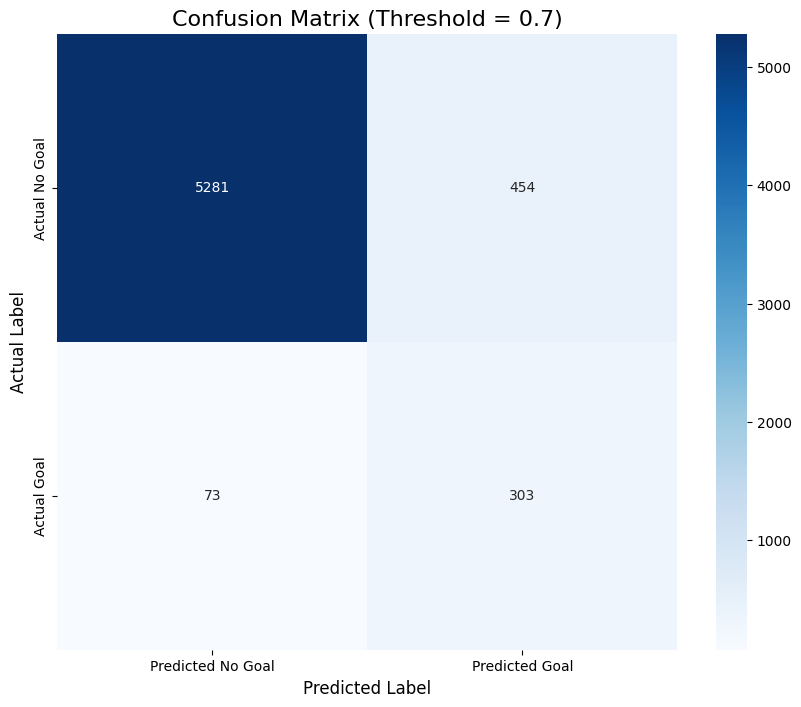


--- ROC Curve and Area Under Curve (AUC) ---


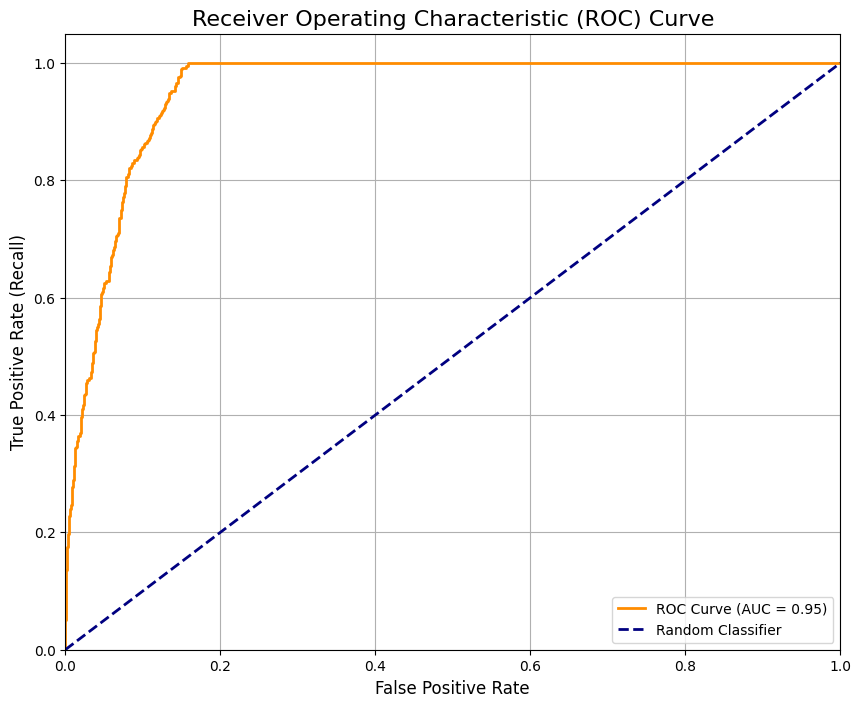


✅ Process finished.


In [34]:
if __name__ == '__main__':
    modelo_final = train_and_evaluate_complete_goal_model(
        df=df,
        train_ids=array_training,
        val_ids=array_validation,
        shot_event_type_id=13,
        custom_threshold=0.7
    )

    if modelo_final:
        print("\n✅ Process finished.")

In [35]:
# Lets save the model
modelo_final.save_model(path + "modelo_final_goal.json")

## Train Model_X